In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import librosa
import yaml

In [2]:
metadata = "../UrbanSound8K/metadata/UrbanSound8K.csv"
df = pd.read_csv(metadata)

labels = df['class'].unique()    # obtaining the class labels
print(labels)

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


## Reflective padding: our alternative to zero padding 

Reflective padding:

    Reflecting the signal at its boundaries instead of zero padding can help preserve the continuity of the signal, preventing alterations of the signal's characteristics, something that might occur with zero padding.
    It can also help reducing artifacts at the edges of the signal and providing a smooth transition from the original signal to the padded region.
    We believe this approach is effective with sound data, due to its symmetric nature.

In [9]:
def reflective_padding(signal, target_duration, target_rate):
    target_duration = target_duration*target_rate
    current_duration = len(signal)
    
    # Calculate the required padding on each side
    padding_needed = target_duration - current_duration
    left_padding = padding_needed // 2
    right_padding = padding_needed - left_padding
    
    # Reflective padding on both sides
    padded_signal = np.pad(signal, (left_padding, right_padding), 'reflect')
    
    return padded_signal

## Loading and resampling all the data

Parameters definition

In [4]:
signal_time = 4    # each signal will have 4 seconds of duration
target_rate = 1000    # resampling frequence

# MFCC parameters
n_mfcc=40
hop_length=round(target_rate*0.0125)
win_length=round(target_rate*0.023)
n_fft=2**14
mfcc_time_size = 4*target_rate//hop_length+1

dataset = []
dataset_mfcc = []

Obtaining all the resampled data

In [16]:
for i in range(1,11):
    _wav_dir_="../UrbanSound8K/audio/fold" + str(i) + '/'
    files = librosa.util.find_files(_wav_dir_)
    fold=np.zeros(shape=[len(files),4*target_rate])
    fold_mfcc=np.zeros(shape=[len(files),n_mfcc,mfcc_time_size])
    idx = 0
    for f in files:
        signal, rate = librosa.load(f, sr=None)
        # print(f"before: {len(signal)}")
        new_signal = librosa.resample(signal, orig_sr=rate, target_sr=target_rate)
        # print(f"after: {len(new_signal)}")
        # print(idx)
        # print(f)
        if len(new_signal) < 4*target_rate:
            new_signal = reflective_padding(new_signal, 4, target_rate)
        fold[idx] = new_signal[:4000]   # reducing the signal to its first 4 seconds
        sig_mfcc = librosa.feature.mfcc(y=new_signal,sr=target_rate,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)
        fold_mfcc[idx] = sig_mfcc[:,:334]   # reducing the mfcc matrix to the elements corresponding to the first 4 seconds of the signal 
        idx += 1
    dataset.append(fold)
    dataset_mfcc.append(fold_mfcc)
    print(f"fold {i} done")

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
fold 6 done
fold 7 done
fold 8 done
fold 9 done
fold 10 done


## Visualizing an audio sample

Originally, the 545th sample of the 5th fold wasn't properly resampled to the target rate of 4000. Instead, the 'librosa.resample' function would return a signal of length 4008.
Thus, we decided to analyze this particular sample.

Resampled signal's length: 4008


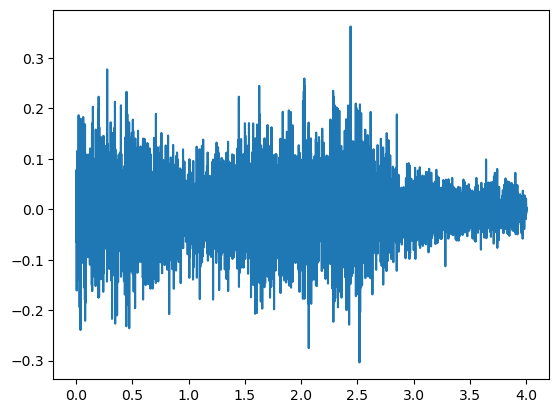

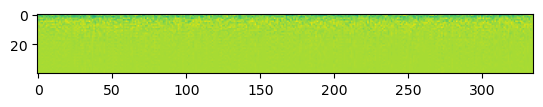

In [11]:
_wav_dir_="../UrbanSound8K/audio/fold5/"
files = librosa.util.find_files(_wav_dir_)
sample = files[545]

signal, rate = librosa.load(sample, sr=None)
new_signal = librosa.resample(signal, orig_sr=rate, target_sr=target_rate)
print(f"Resampled signal's length: {len(new_signal)}")
sig_mfcc =librosa.feature.mfcc(y=new_signal,sr=target_rate,n_fft=n_fft,hop_length=hop_length,win_length=win_length,n_mfcc=n_mfcc)

plt.figure()
plt.plot(np.asarray(list(range(4008)))/1000,new_signal)
plt.show()

plt.figure()
plt.imshow(sig_mfcc)
plt.show()

Since there is no visible anomaly in this audio sample, we decided to truncate the extra signal length that was causing the anomaly and applied this rule to the dataset as a whole.

### Saving the datasets

In [21]:
with open("datasets/dataset.yaml", 'w') as file:
    yaml.dump(dataset,file)
    
with open("datasets/dataset_mfcc.yaml", 'w') as file:
    yaml.dump(dataset_mfcc,file)

In [26]:
dataset[0]

array([[-5.11112344e-03,  2.74013961e-04,  1.53768610e-03, ...,
         6.40918093e-04,  2.05874065e-04, -9.40632832e-04],
       [ 1.09241065e-03,  2.03327928e-03,  2.20916467e-03, ...,
         7.90315564e-04, -1.64408074e-03, -1.07350131e-03],
       [-1.16939482e-03,  5.62598812e-04, -2.01653223e-04, ...,
        -5.62043278e-04, -1.89873599e-03, -5.69444266e-04],
       ...,
       [-5.80264367e-02, -6.94471747e-02,  1.08468927e-01, ...,
        -8.21292587e-03,  3.37154791e-02,  1.23793036e-01],
       [ 2.84713024e-04, -1.57766597e-04, -2.65374169e-04, ...,
        -6.47874875e-03,  3.20127420e-03,  1.28699420e-03],
       [-2.62785295e-04, -2.79129104e-04, -1.18414615e-03, ...,
         7.88552221e-04,  1.20419085e-04,  5.44056064e-04]])

In [31]:
for i in range(2,11):
    path1 = "datasets/fold" + str(i) + ".csv"
    # path2 = "datasets/mfcc_fold" + str(i) + ".csv"
    np.savetxt(path1, dataset[i-1], delimiter=',', fmt='%f')
    # np.savetxt(path2, dataset_mfcc[i-1], delimiter=',', fmt='%f')

In [29]:
# Problem saving the mfcc dataset
np.savetxt("datasets/mfcc_fold1", dataset_mfcc[0], delimiter=',', fmt='%f')

ValueError: Expected 1D or 2D array, got 3D array instead